In [10]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [11]:
df = pd.read_csv(os.path.join('train.csv', 'train.csv'))

In [46]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Cleaning the text

In [47]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rishe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocess

In [48]:
from tensorflow.keras.layers import TextVectorization

In [49]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [50]:
MAX_FEATURES = 200000 # number of words in the vocab

In [51]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [52]:
vectorizer.adapt(X.values)

In [56]:
vectorizer('Hello world, How are you?')

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263,  73,  20,   7], dtype=int64)>

In [57]:
vectorized_text = vectorizer(X.values)

In [58]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) 

In [59]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### Sequential Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model = Sequential()
# The embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 7184s 1s/step - loss: 0.0631 - val_loss: 0.0455
Epoch 2/5
6981/6981 [==============================] - 7447s 1s/step - loss: 0.0452 - val_loss: 0.0400
Epoch 3/5
6981/6981 [==============================] - 7423s 1s/step - loss: 0.0406 - val_loss: 0.0362
Epoch 4/5
6981/6981 [==============================] - 7361s 1s/step - loss: 0.0361 - val_loss: 0.0310
Epoch 5/5
6981/6981 [==============================] - 7884s 1s/step - loss: 0.0325 - val_loss: 0.0292


In [18]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

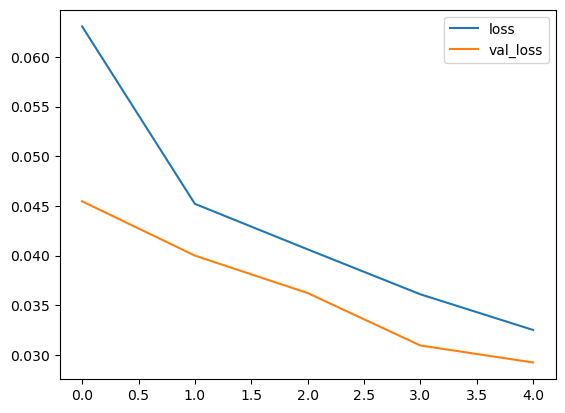

In [19]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [20]:
model.save('DL_model_5.keras')

### Testing

In [62]:
import numpy as np
from keras.models import load_model

# Load the Keras model
model = load_model('DL_model_5.keras')


In [97]:
input_text = vectorizer('Dont humiliate others')

In [98]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 0s 204ms/step


In [99]:
res

array([[1.37372734e-02, 1.14683274e-07, 1.68327184e-03, 2.91923352e-04,
        3.13254632e-03, 7.32691842e-04]], dtype=float32)

In [100]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0]])

In [31]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [89]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [90]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 294ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [93]:
res

array([[4.5451134e-01, 3.8647695e-04, 2.1744927e-02, 1.3088284e-02,
        5.7589013e-02, 1.4322280e-02]], dtype=float32)

In [26]:
res.shape

(1, 6)

### Evaluate model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 249ms/step


In [33]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8689534068107605, Recall:0.8396600484848022, Accuracy:0.49949848651885986
